In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EX model defining and training
---

In [ ]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import drive.MyDrive.scripts.utils as util

from datetime import datetime
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

warnings.filterwarnings('ignore')

## Configuration parameters

In [ ]:
''' DATASET
-------------------------------------------------------
'''

# Dataset size
SIZE = 'month' # Alternative: 'day'

# Insert preferred ship and date here
FILE = {
    'ship': '13218',
    'year': '2023',
    'month': '9',
    'day': '4'
}

if (SIZE == 'month'):
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}'
else:
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}-{FILE["day"]}'


# NB: Changing this will alter what attributes the model will be trained to predict
cylinders = ['01EX', '02EX', '03EX', '04EX', '05EX', '06EX', '07EX', '08EX']

# NB: Changing this will alter what attributes the model will receive as input
engine    = ['21EL', '20EL', '25EL', '87XS', '96FG', '31EL', '31EL_LIM', '78XS', '82XS']





''' MODEL
-------------------------------------------------------
'''

# Model version
VERSION = 'v1'

# Model architecture
ARCHITECTURE = 'LSTM'

# Prediction tag name
TAG_NAME = 'EX'

# Scaler: Active scaler
SCALING_ALGORITHM = 'minmax'
SCALER_PATH       = '/content/drive/MyDrive/scalers/'
SCALER_NAME       = f'{TAG_NAME}-{SCALING_ALGORITHM}-Dataset[{SHORT}]'

# Model: Input and output attributes
X_ATTRIBUTES = ['87XS']
Y_ATTRIBUTES = cylinders

# Training: Early callback monitors
CALLBACK_LISTENERS = ['loss', 'val_loss']
CALLBACK_PATIENCE  = 5                   # [ 5, 10, 15, 20]

# Model: Compilation
TEST_SIZE_PROPORTION = 0.2
LSTM_LAYER_1_UNITS   = 64
LSTM_LAYER_2_UNITS   = 128
DROPOUT              = 0.25
OPTIMIZER            = 'rmsprop'  # Look into other optimizer functions
LOSS_FUNCTION        = 'mse'

# Training: Epochs and batch size
EPOCHS     = 15                           # [15, 20, 25, 60]
BATCH_SIZE = 64                           # [64, 16, 32, 64]

# Path to model directory
DIR = '/content/drive/MyDrive/models/'





''' OTHER
-------------------------------------------------------
'''

# Getting current date
DATE = datetime.today().strftime('%Y-%m-%d')

# Decimal place to round
ROUND = 3

## Importing dataset

__All attributes except 01EX, 02EX, ..., 08EX:__

```python
engine = [
    '21EL', '20EL', '25EL', '87XS', '96FG', '31EL', '31EL_LIM',
    '78XS', '82XS', '10EX', '11EX', '12EX', '05HT', '06HT', '10HT',
    '05LT', '06LT', '10LT', '05NC', '10NC', '05LO', '06LO', '10LO',
    '11LO', '13LO', '14LO', '05CA', '08CA', '21CA', '10SA', '14SA',
    '05DO', '10DO', '12DO', '13DO'
]

engine = ['21EL', '20EL', '25EL', '87XS', '96FG', '31EL', '31EL_LIM', '78XS', '82XS']
```

In [ ]:
if SIZE == 'month':
  try:
    df = util.open_dataset_at_month(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_month(FILE)
else:
  try:
    df = util.open_dataset_at_date(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_date(FILE)
df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.2 MB/s eta 0:00:00


,B21CA,14LO,24EL,07HT,54XA,55XA,57XA,16DO,15LO,05XS,...,05EX,01EX,06LO,06EX,07EX,08EX,05HT,87XS,missingMsgCount,frequencyMsgCount
time,,,,,,,,,,,,,,,,,,,,,
2023-09-01 00:00:00,0.052,4.572,5.288,71.2,5.0,5.0,5.0,6.826,4.567,0.0,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:01,0.052,4.502,5.168,71.2,5.0,5.0,5.0,7.341,4.553,0.0,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:02,0.047,4.514,5.240,71.2,5.0,5.0,5.0,7.260,4.510,0.0,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:03,0.047,4.485,5.216,71.2,5.0,5.0,5.0,7.543,4.416,0.0,...,245.0,218.0,66.0,233.0,225.0,197.0,69.9,0.000000,NaN,NaN
2023-09-01 00:00:04,0.054,4.485,5.312,71.1,5.0,5.0,5.0,7.899,4.495,0.0,...,245.0,218.0,66.0,233.0,225.0,197.0,69.9,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 23:59:55,0.550,4.372,11.088,79.0,5.0,5.0,5.0,7.138,4.423,0.0,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,37.331078,NaN,NaN
2023-09-30 23:59:56,0.538,4.343,11.032,79.0,5.0,5.0,5.0,6.797,4.293,0.0,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,36.486485,NaN,NaN
2023-09-30 23:59:57,0.531,4.381,10.968,79.0,5.0,5.0,5.0,7.439,4.416,0.0,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,35.641890,NaN,NaN


## Data cleanup and processing

### Fill cells containing <code>NaN</code> with attribute mean

In [ ]:
df.fillna(df.mean(), inplace=True)

### Removing attributes with constant values and producing modified dataset

In [ ]:
df, engine, cylinders, controlled_parameters = util.produce_modified_dataset(df, engine, cylinders)
df

,21EL,25EL,87XS,01EX,02EX,03EX,04EX,05EX,06EX,07EX,08EX
time,,,,,,,,,,,
2023-09-01 00:00:00,902.0,11580.0,0.000000,218.0,228.0,205.0,212.0,246.0,233.0,225.0,197.0
2023-09-01 00:00:01,903.0,11580.0,0.000000,218.0,227.0,205.0,212.0,246.0,233.0,225.0,197.0
2023-09-01 00:00:02,901.0,11580.0,0.000000,218.0,227.0,205.0,212.0,246.0,233.0,225.0,197.0
2023-09-01 00:00:03,902.0,11580.0,0.000000,218.0,227.0,205.0,212.0,245.0,233.0,225.0,197.0
2023-09-01 00:00:04,901.0,11580.0,0.000000,218.0,227.0,205.0,212.0,245.0,233.0,225.0,197.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 23:59:55,901.0,21110.0,37.331078,335.0,342.0,341.0,323.0,332.0,339.0,332.0,323.0
2023-09-30 23:59:56,902.0,21010.0,36.486485,335.0,342.0,341.0,323.0,332.0,339.0,332.0,323.0
2023-09-30 23:59:57,899.0,20890.0,35.641890,335.0,342.0,341.0,323.0,332.0,339.0,332.0,323.0


### Filtering

In [ ]:
df = util.remove_rows_at(df, 'df["21EL"] >= 885')
df = util.remove_rows_at(df, 'df["25EL"] >= 14000')

## Qualitative dataset exploration

### Exploring correlating relationships

__For larger heatmaps__:

```python
correlation_matrix = df.corr()

title = 'Correlation Heatmap'
ship = f'\nShip: {FILE["ship"]}'
date = f'\nDate: {FILE["year"]}-{FILE["month"]}-{FILE["day"]}'

plt.figure(figsize=(50, 40))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', annot_kws={"fontsize": 22})
plt.title(title + ship + date)
plt.xticks(rotation=45, fontsize=20)  
plt.yticks(rotation=45, fontsize=18)
plt.show()
```

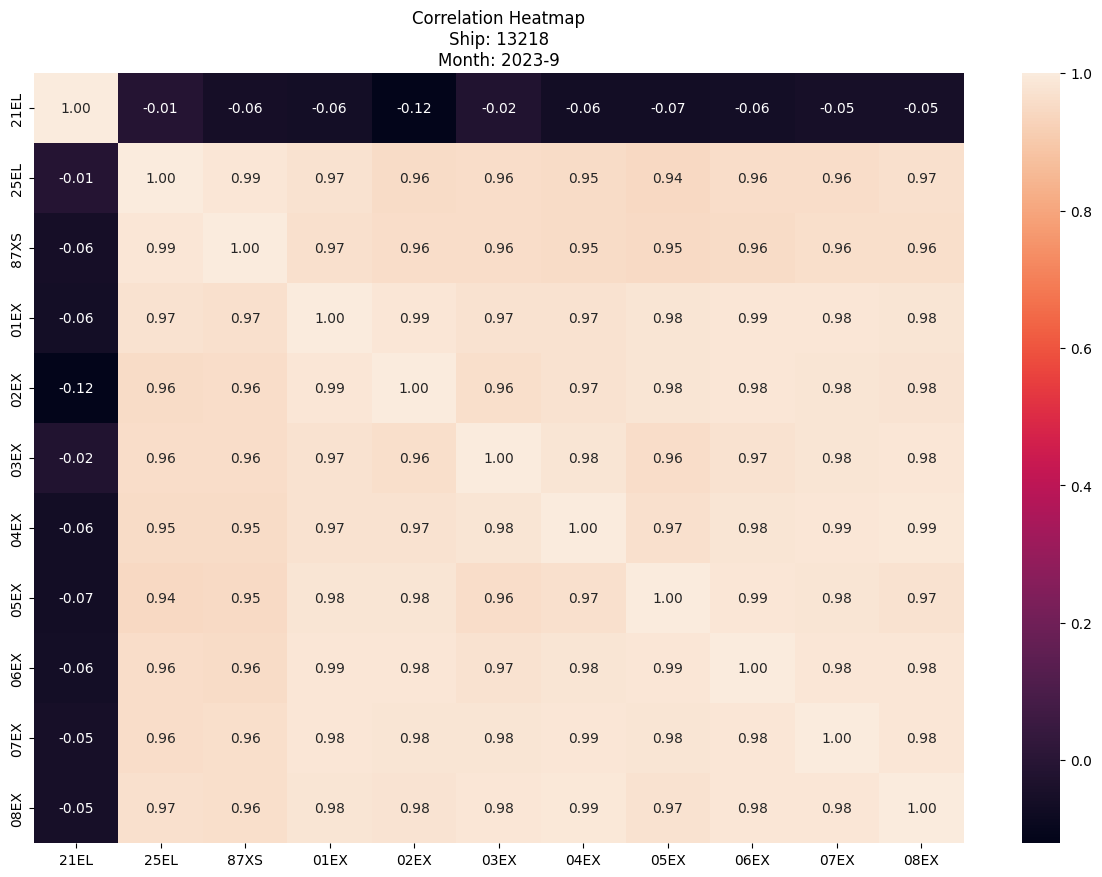

In [ ]:
correlation_matrix = df.corr()

title = 'Correlation Heatmap'
ship = f'\nShip: {FILE["ship"]}'

if SIZE == 'month':
  date = f'\nMonth: {FILE["year"]}-{FILE["month"]}'
else:
  date = f'\nDate: {FILE["year"]}-{FILE["month"]}-{FILE["day"]}'

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title(title + ship + date)
plt.show()

## Model creation

### Designing and training the model

Epoch 1/15
25635/25635 [==============================] - 174s 7ms/step - loss: 2466.5093 - val_loss: 42.5882
Epoch 2/15
25635/25635 [==============================] - 166s 6ms/step - loss: 169.2717 - val_loss: 40.8086
Epoch 3/15
25635/25635 [==============================] - 167s 7ms/step - loss: 164.1787 - val_loss: 41.4760
Epoch 4/15
25635/25635 [==============================] - 167s 7ms/step - loss: 159.4904 - val_loss: 44.6119
Epoch 5/15
25635/25635 [==============================] - 167s 6ms/step - loss: 154.6632 - val_loss: 46.8354
Epoch 6/15
25635/25635 [==============================] - 166s 6ms/step - loss: 150.1202 - val_loss: 39.4872
Epoch 7/15
25635/25635 [==============================] - 166s 6ms/step - loss: 145.5643 - val_loss: 37.6892
Epoch 8/15
25635/25635 [==============================] - 166s 6ms/step - loss: 141.2472 - val_loss: 41.9242
Epoch 9/15
25635/25635 [==============================] - 166s 6ms/step - loss: 136.7053 - val_loss: 38.1109
Epoch 10/15
25635/

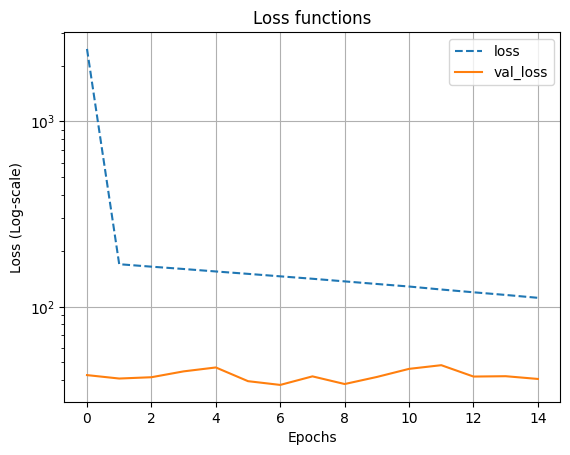

In [ ]:
Y_ATTRIBUTES = cylinders

# Setting desired input and output attributes
num_attributes_x = len(X_ATTRIBUTES)
num_attributes_y = len(Y_ATTRIBUTES)
timesteps = 1

dfx = df[X_ATTRIBUTES]
dfy = df[Y_ATTRIBUTES]


# Scaling algorithms
SCALERS = {
    'standard':     StandardScaler().fit(dfx),
    'minmax':       MinMaxScaler(feature_range=(0, 1)).fit(dfx),     # This scaler has given the best results
    'robust':       RobustScaler().fit(dfx),
    'normalizer':   Normalizer().fit(dfx)
}

# Specifying which scaler to use
scaler = SCALERS[ SCALING_ALGORITHM ]        # NB: Scaler must be the same as the one used for training
joblib.dump(scaler, f'{SCALER_PATH}{SCALER_NAME}.joblib')
dfx = pd.DataFrame(scaler.transform(dfx))


X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=TEST_SIZE_PROPORTION, shuffle=False)

X_train = X_train.to_numpy().reshape(X_train.shape[0], timesteps, num_attributes_x)
y_train = y_train.to_numpy().reshape(y_train.shape[0], timesteps, num_attributes_y)

X_test  =  X_test.to_numpy().reshape(X_test.shape[0],  timesteps, num_attributes_x)
y_test  =  y_test.to_numpy().reshape(y_test.shape[0],  timesteps, num_attributes_y)


# Define LSTM model
model = Sequential()
model.add( Bidirectional(LSTM(LSTM_LAYER_1_UNITS, input_shape=(timesteps, num_attributes_x), return_sequences=True)) )
model.add( Bidirectional(LSTM(LSTM_LAYER_2_UNITS, return_sequences=True)) )
model.add( Dropout(DROPOUT) )
model.add( Dense(num_attributes_y) )


# Compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)


# Adding early stopping listeners for validation metrics
callbacks = []
for listener in CALLBACK_LISTENERS:
  callbacks.append( EarlyStopping(monitor=listener, patience=CALLBACK_PATIENCE, restore_best_weights=True) )


# Training the model
trained_model = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_data=(X_test, y_test), callbacks=callbacks)


# Plotting the loss as a function of epochs
print('\n')
plt.plot(trained_model.history['loss'],     label='loss', linestyle='dashed')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log-scale)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### Predicting 01EX, 02EX, ..., 08EX

In [ ]:
# Perform predictions
predictions = model.predict(X_test)

# Split the transposed array into 8 separate arrays
print(f'\nDimensions of the array before:\t {predictions.shape}')

# Predictions are on the format (num_observations x timesteps x num_attributes_y)
# We need to convert it to the format (num_attributes_y x num_observations)
predictions = np.transpose(predictions, (2, 1, 0))
predictions = np.array([predictions[i].flatten() for i in range(predictions.shape[0])])

print(f'Dimensions of the array after:\t {predictions.shape}')
print(f'\nPredictions:\n{predictions}')

12818/12818 [==============================] - 31s 2ms/step

Dimensions of the array before:	 (410157, 1, 8)
Dimensions of the array after:	 (8, 410157)

Predictions:
[[341.9829  336.85034 335.86084 ... 328.9206  334.81763 339.54553]
 [352.39557 347.43628 346.44373 ... 339.2987  345.38715 350.08203]
 [338.19928 334.52563 334.05496 ... 332.16183 333.63663 336.21667]
 ...
 [345.98218 341.56656 340.67612 ... 334.21973 339.72623 343.9293 ]
 [335.21283 331.2329  330.5532  ... 326.35098 329.86737 333.24115]
 [328.0424  322.9569  322.2784  ... 319.2215  321.65625 325.31125]]


### Comparison of mean value of predictions and actual values

In [ ]:
# Preparing the actual values of 01EX, 02EX, ..., 08EX
y_test = np.transpose(y_test, (2, 1, 0))
y_test = np.array([y_test[i].flatten() for i in range(y_test.shape[0])])

print('\tActual\t\tPrediction\tDifference')
print(f'\t{42 * "-"}')

# Printing mean of actual, prediction, and the difference between them
for i in range(num_attributes_y):
  actual  = round(float(y_test[i].mean()), ROUND)
  predict = round(float(predictions[i].mean()), ROUND)
  diff    = round(abs(actual - predict), ROUND)

  print(f'{cylinders[i]}:\t{actual}\t\t{predict}\t\t{diff}')

	Actual		Prediction	Difference
	------------------------------------------
01EX:	350.011		347.002		3.009
02EX:	354.548		357.056		2.508
03EX:	348.843		343.024		5.819
04EX:	332.11		332.728		0.618
05EX:	339.986		339.182		0.804
06EX:	351.335		349.817		1.518
07EX:	341.662		339.756		1.906
08EX:	335.679		334.39		1.289


### Producing qualitative and quantitative accuracy

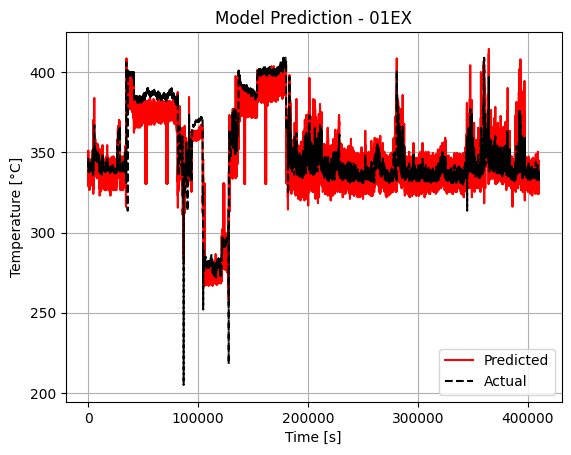


Mean Squared Error: 57.06171275677715
Root Mean Squared Error: 7.553920356793362
Mean Absolute Error: 5.737186949213133
R-squared: 0.9249313930360684 




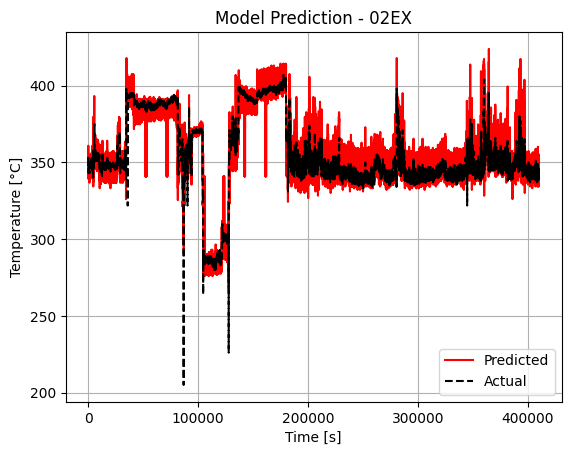


Mean Squared Error: 48.895728508966464
Root Mean Squared Error: 6.99254806983595
Mean Absolute Error: 5.439031505658687
R-squared: 0.9239019696150015 




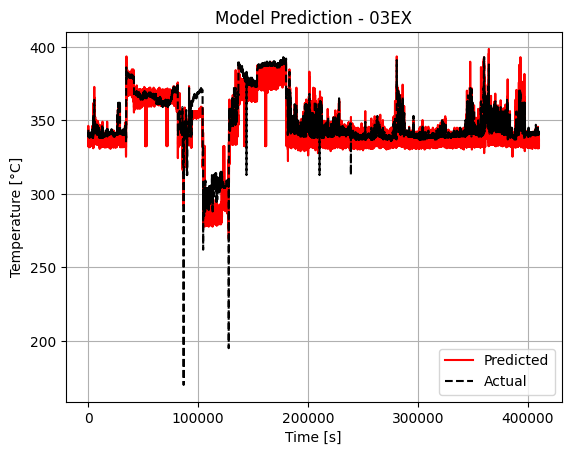


Mean Squared Error: 68.53858140709154
Root Mean Squared Error: 8.278803138563662
Mean Absolute Error: 6.414582241878275
R-squared: 0.8126710480679569 




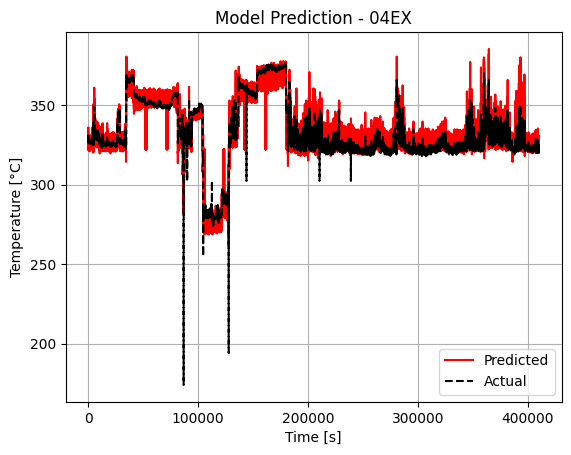


Mean Squared Error: 25.782363240044255
Root Mean Squared Error: 5.077633626015593
Mean Absolute Error: 3.8568364819488212
R-squared: 0.9344599476883444 




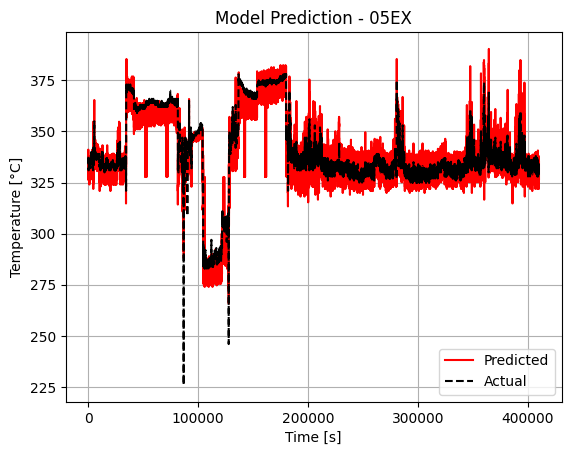


Mean Squared Error: 29.06942479536422
Root Mean Squared Error: 5.391606884349435
Mean Absolute Error: 4.082331062297369
R-squared: 0.9206925741691326 




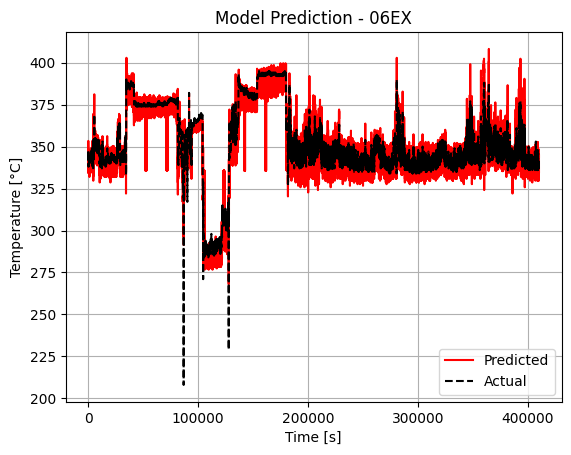


Mean Squared Error: 31.315066028954938
Root Mean Squared Error: 5.595986600140759
Mean Absolute Error: 4.108573612266772
R-squared: 0.9357423823108936 




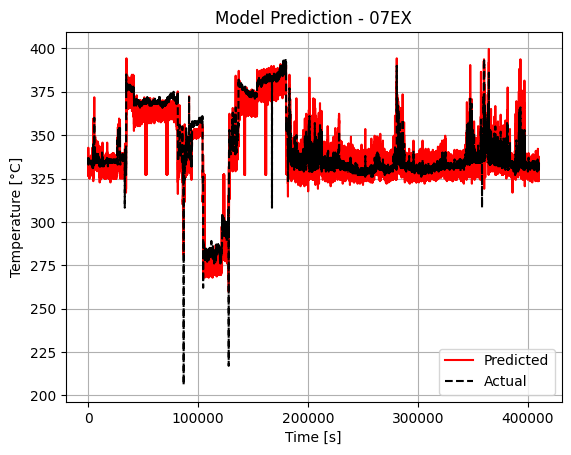


Mean Squared Error: 32.77938764114662
Root Mean Squared Error: 5.725328605516597
Mean Absolute Error: 4.292773868533838
R-squared: 0.9351766151736216 




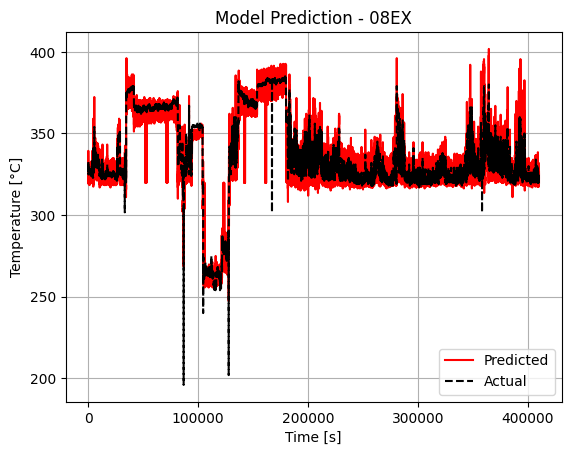


Mean Squared Error: 31.333751528905132
Root Mean Squared Error: 5.597655895900099
Mean Absolute Error: 3.8747069047791127
R-squared: 0.9533879309600894 




In [ ]:
# Looping through each array of attribute predictions
for i in range(num_attributes_y):

  feature = cylinders[i]

  # Converting attribute predictions and actual values to numpy arrays
  predict = predictions[cylinders.index(feature)]
  actual  = y_test[i]

  # Plotting line graphs for prediction vs. actual
  plt.plot(predict, label='Predicted', color='red',   linestyle='-' )
  plt.plot(actual,  label='Actual',    color='black', linestyle='--')

  plt.xlabel('Time [s]')
  plt.ylabel('Temperature [°C]')
  plt.title(f'Model Prediction - {feature}')

  plt.legend()
  plt.grid()
  plt.show()

  # Calculating quantitative accuracy measures
  mse  = mean_squared_error(actual, predict)
  mae  = mean_absolute_error(actual, predict)
  r2   = r2_score(actual, predict)
  rmse = np.sqrt(mse)

  # Printing quantitative accuracy measures
  print(f'\nMean Squared Error: {mse}')
  print(f'Root Mean Squared Error: {rmse}')
  print(f'Mean Absolute Error: {mae}')
  print(f'R-squared: {r2} \n\n')

### Exporting the trained model to the drive

In [ ]:
VERSION = 'v1'
trained_model.model.save(f'{DIR}{DATE}-{VERSION}-{ARCHITECTURE}-{TAG_NAME}.h5')

# TODO

* Bruk konstantene øverst i scriptet til å gjøre filen mer dynamisk
* Sjekk ut andre plot-verktøy enn matplotlib
